In [1]:
# Import necesary packages:
import sympy
import math
import copy

In [2]:
#Set up sympy to display outputs after a latex conversion.
from sympy.interactive import printing
printing.init_printing(use_latex=True)

In [3]:
N, S, I_W, I_Z, I_WZ, beta_W, beta_Z, gamma, gamma_T, epsilon, q, rho, phi = sympy.symbols('N S I_W I_Z I_WZ beta_W beta_Z gamma gamma_T epsilon q rho phi')

# 1 Endemic Equilibria Stability Anlyses of the Exclusive Infection Model from Spicknall et al (2013)

## 1.1 Deriving Equilibria and Determining Their Stability

In [4]:
Eqn_S = -beta_W/N*I_W*S-beta_Z/N*I_Z*S+gamma*(1-epsilon)*I_W+gamma_T*epsilon*I_W+gamma*I_Z
Eqn_I_W = beta_W/N*I_W*S-gamma*(1-epsilon)*I_W-gamma_T*epsilon*I_W
Eqn_I_Z = beta_Z/N*I_Z*S-gamma*I_Z

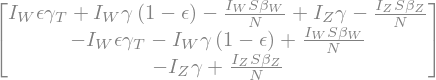

In [5]:
ODEs = sympy.Matrix([Eqn_S,Eqn_I_W,Eqn_I_Z])
ODEs

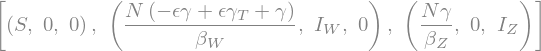

In [6]:
equilibria = sympy.solve(ODEs,[S, I_W, I_Z])
equilibria

The disease free equilibrium (DFE) is the first vector.

In [7]:
DFE = equilibria[0]

We are not interested in whether the disease free equilibrium (DFE), the first equilibria, is stable. This can be found through deriving R0 using PyGom's matrix methodology for determining R0. 

Lets look at the stability of the non-DFEs, following recipe 8.2 of Otto & Day (2007). Needs to create Jacobian Matrix of the models ODEs.

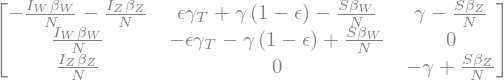

In [8]:
J_of_ODEs = ODEs.jacobian(X=[S,I_W,I_Z])
J_of_ODEs

Substitute the 1st non-disease free equilibrium (non-DFE) into the Jacobian matrix and determine Eigen values.

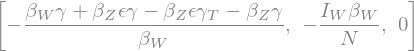

In [9]:
non_DFE_1 = {'S':equilibria[1][0],'I_W':equilibria[1][1],'I_Z':equilibria[1][2]}

J_of_ODEs_non_DFE_1 = J_of_ODEs.subs(non_DFE_1)
J_of_ODEs_non_DFE_1

eigs_J_non_DFE_1 = J_of_ODEs_non_DFE_1.eigenvals()
# The above code line enters the Eigen values as keys to a dictionary. 
# It would be more useful to have them as elements in a vector.
eigs_J_non_DFE_1 = [k  for  k in  eigs_J_non_DFE_1.keys()] 
eigs_J_non_DFE_1

Substitute the 2nd non-disease free equilibrium (non-DFE) into the Jacobian matrix and determine Eigen values.

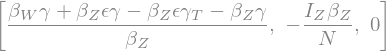

In [10]:
non_DFE_2 = {'S':equilibria[2][0],'I_W':equilibria[2][1],'I_Z':equilibria[2][2]}

J_of_ODEs_non_DFE_2 = J_of_ODEs.subs(non_DFE_2)
J_of_ODEs_non_DFE_2

eigs_J_non_DFE_2 = J_of_ODEs_non_DFE_2.eigenvals()
# The above code line enters the Eigen values as keys to a dictionary. 
# It would be more useful to have them as elements in a vector.
eigs_J_non_DFE_2 = [k  for  k in  eigs_J_non_DFE_2.keys()]
eigs_J_non_DFE_2

## 1.2 Function for Determining the Stable Endemic Equilibrium Infection Prevelance

In [11]:
# A rounding to sigfig function will prove useful:
def round_sf(number, significant):
    '''
    Rounds to a specified number of signicant figures. 
    '''
    return round(number, significant - len(str(number)))

In [12]:
def exclus_inf_end_equil(param_values):
    '''
    Calculates the non-disease free equilibria for the exclusive infection model ,
    as out lined in Spicknall et al 2013. Reuturning any non-DFE that are 
    that are biologically reasonable and locally stable.
    '''
    # Note if both strains have R0 values <1 there is no point in using this function.
    
    equil_pops = []
    # Setup Equilibrium populations as an empty list. If any of the endemic 
    # equilibria are found to biologically feasible and stable they are appended to the list.
    
    #Basic Reproductive numbers from Spicknall 2013
    R0_W = beta_W/(gamma*(1-epsilon)+gamma_T*epsilon)
    R0_W = R0_W.subs(param_values)
    R0_Z = beta_Z/gamma
    R0_Z = R0_Z.subs(param_values)
    
    #Formula for the non-Disease Free Equilibria has been worked out in a jupyter notebook
    #and pasted here. NOTE with the first non-DFE the I_W population = N-S (I_Z=0),
    # and with the second non-DFE the I_Z population = N-S (I_W=0).
    # Therefore, only the formule for S are needed (see jupyter notebook).
    S_non_DFE_1 = N*(-epsilon*gamma + epsilon*gamma_T + gamma)/beta_W
    S_non_DFE_1 = S_non_DFE_1.subs(param_values)
    I_W_non_DFE_1 = param_values['N']-S_non_DFE_1
    I_Z_non_DFE_1 = 0
    S_non_DFE_2 = N*gamma/beta_Z
    S_non_DFE_2 = S_non_DFE_2.subs(param_values)
    I_W_non_DFE_2 = 0
    I_Z_non_DFE_2 = param_values['N']-S_non_DFE_2
    
        
    #The Eigen values associated with jacobian matricies for the non-DFE have been 
    #derived in a jupyter notebook and pasted here.
    eigs_J_non_DFE_1 = [-(beta_W*gamma + beta_Z*epsilon*gamma - beta_Z*epsilon*gamma_T - beta_Z*gamma)/beta_W,
                        -I_W*beta_W/N,
                        0]
    eigs_J_non_DFE_2 = [(beta_W*gamma + beta_Z*epsilon*gamma - beta_Z*epsilon*gamma_T - beta_Z*gamma)/beta_Z,
                        -I_Z*beta_Z/N,
                        0]
    
    if math.isnan(S_non_DFE_1) or math.isnan(I_W_non_DFE_1) or math.isnan(I_Z_non_DFE_1) or math.isinf(S_non_DFE_1) or math.isinf(I_W_non_DFE_1) or math.isinf(I_Z_non_DFE_1):
        DFE_1_feasable = False
    else:
        DFE_1_feasable = True
    
    if DFE_1_feasable and round_sf(S_non_DFE_1,2) >= 0 and round_sf(I_W_non_DFE_1,2) >= 0 and round_sf(I_Z_non_DFE_1,2) >= 0:
        DFE_1_feasable = True
    else:
        DFE_1_feasable = False
    
    if math.isnan(S_non_DFE_2) or math.isnan(I_W_non_DFE_2) or math.isnan(I_Z_non_DFE_2) or math.isinf(S_non_DFE_2) or math.isinf(I_W_non_DFE_2) or math.isinf(I_Z_non_DFE_2):
        DFE_2_feasable = False
    else:
        DFE_2_feasable = True
    
    if DFE_2_feasable and round_sf(S_non_DFE_2,2) >= 0 and round_sf(I_W_non_DFE_2,2) >= 0 and round_sf(I_Z_non_DFE_2,2) >= 0:
        DFE_2_feasable = True
    else:
        DFE_2_feasable = False
    
    #Determine if R0_W is >=1, R0_Z<1 and the first DFE is biologically feasable.
    if R0_W.subs(param_values)>=1 and R0_Z.subs(param_values)<1 and DFE_1_feasable:
        equil_pops.append({'S':S_non_DFE_1,'I_W':I_W_non_DFE_1,'I_Z':I_Z_non_DFE_1})
    
    #Determine if R0_Z is >=1, R0_W<1 and the second DFE is biologically feasable.
    if R0_Z.subs(param_values)>=1 and R0_W.subs(param_values)<1 and DFE_2_feasable:   
        equil_pops.append({'S':S_non_DFE_2,'I_W':I_W_non_DFE_2,'I_Z':I_Z_non_DFE_2})
    
    #Determine if R0_W is >=1, R0_Z>=1 and the first DFE is biologically feasable but the second is not.
    if R0_W.subs(param_values)>=1 and R0_Z.subs(param_values)>=1 and DFE_1_feasable and DFE_2_feasable == False:
        equil_pops.append({'S':S_non_DFE_1,'I_W':I_W_non_DFE_1,'I_Z':I_Z_non_DFE_1})
    
    #Determine if R0_W is >=1, R0_Z>=1 and the second DFE is biologically feasable but the first is not.
    if R0_W.subs(param_values)>=1 and R0_Z.subs(param_values)>=1 and DFE_1_feasable  == False and DFE_2_feasable:
        equil_pops.append({'S':S_non_DFE_2,'I_W':I_W_non_DFE_2,'I_Z':I_Z_non_DFE_2})
        
    #Determine if R0_W is >=1, R0_Z>=1 and both DFEs are biologically feasable.
    if R0_W.subs(param_values)>=1 and R0_Z.subs(param_values)>=1 and DFE_1_feasable and DFE_2_feasable:   
        # If all the values for non-DFE_1 are >= 0, evaluate eigenavalues 
        # associated with the Jacobian matrix of non-DFE_1.
        # Need to be able to subsititute in equilibria formula, as well as the param values:
        vals_to_subs = copy.deepcopy(param_values)
        vals_to_subs['S'] = S_non_DFE_1
        vals_to_subs['I_W'] = I_W_non_DFE_1
        vals_to_subs['I_Z'] = I_Z_non_DFE_1
        if eigs_J_non_DFE_1[0].subs(vals_to_subs) <=0 and eigs_J_non_DFE_1[1].subs(vals_to_subs)<=0:
            # If the non-vero eigenavalues associated with the Jacobian matrix  
            # of non-DFE_1 are <= 0, the equil_pops is appended with non-DFE_1, 
            # as it is locally stable.
            equil_pops.append({'S':S_non_DFE_1,'I_W':I_W_non_DFE_1,'I_Z':I_Z_non_DFE_1})
        
        # If all the values for non-DFE_2 are >= 0, evaluate eigenavalues 
        # associated with the Jacobian matrix of non-DFE_2.
        # Need to be able to subsititute in equilibria formula, as well as the param values:
        vals_to_subs = copy.deepcopy(param_values)
        vals_to_subs['S'] =  S_non_DFE_2
        vals_to_subs['I_W'] = I_W_non_DFE_2
        vals_to_subs['I_Z'] = I_Z_non_DFE_2
        if eigs_J_non_DFE_2[0].subs(vals_to_subs) <=0 and eigs_J_non_DFE_2[1].subs(vals_to_subs)<=0:
            # If the non-vero eigenavalues associated with the Jacobian matrix  
            # of non-DFE_2 are <= 0, the equil_pops is appended with non-DFE_2, 
            # as it is locally stable.
            equil_pops.append({'S':S_non_DFE_2,'I_W':I_W_non_DFE_2,'I_Z':I_Z_non_DFE_2})
    
    return(equil_pops)

# 2 Endemic Equilibria Stability Anlyses of the Replacement Infection Model from Spicknall et al (2013)

## 2.1 Deriving Equilibria

In [13]:
Eqn_S = -beta_W/N*I_W*S-beta_Z/N*I_Z*S+gamma*(1-epsilon)*I_W+gamma_T*epsilon*I_W+gamma*I_Z
Eqn_I_W = beta_W/N*I_W*S-gamma*(1-epsilon)*I_W-gamma_T*epsilon*I_W+(beta_W/N-beta_Z/N)*I_W*I_Z
Eqn_I_Z = beta_Z/N*I_Z*S-gamma*I_Z+(beta_Z/N-beta_W/N)*I_W*I_Z

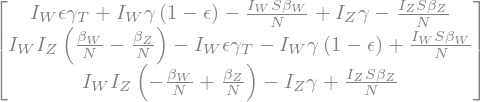

In [14]:
ODEs = sympy.Matrix([Eqn_S,Eqn_I_W,Eqn_I_Z])
ODEs

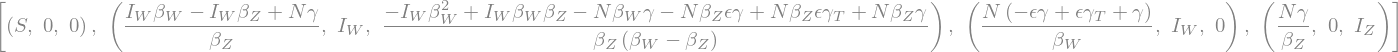

In [15]:
equilibria = sympy.solve(ODEs,[S, I_W, I_Z])
equilibria

The 2nd vector is difficult to interprate I_W appearing in all three elements, it requires some substituiton work.

### 2.1.1 Dealing with Unusual Equilibria

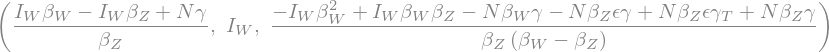

In [16]:
unusaul_equil = copy.deepcopy(equilibria[1])
unusaul_equil

#### 2.1.1.1 Treating as a Simultanious Equation Problem. 

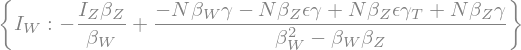

In [17]:
exp2_as_simul=unusaul_equil[1]-I_W
exp3_as_simul=unusaul_equil[2]-I_Z
sol = sympy.solve((exp2_as_simul,exp3_as_simul),(I_W,I_Z))
sol

#### 2.1.1.2 Substituting $S=N-(I_W+I_Z)$ and treating as a Simultanious Equation Problem. 

Lets try substituting $S=N-(I_W+I_Z)$ into the 2nd and 3rd equation:

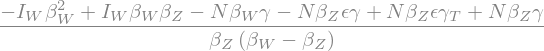

In [18]:
S_in_N_terms = N-(I_W+I_Z)
exp2_sub_S_in_N_terms = sympy.simplify(unusaul_equil[1].subs(S,S_in_N_terms))
exp3_sub_S_in_N_terms = sympy.simplify(unusaul_equil[2].subs(S,S_in_N_terms))
display(exp2_sub_S_in_N_terms,exp3_sub_S_in_N_terms)

Solving both equstions for I_W and I_Z

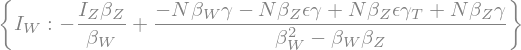

In [19]:
exp2_sub_S_in_N_terms=exp2_sub_S_in_N_terms-I_W
exp3_sub_S_in_N_terms=exp3_sub_S_in_N_terms-I_Z
sol = sympy.solve((exp2_sub_S_in_N_terms,exp3_sub_S_in_N_terms),(I_W,I_Z))
sol

#### There is no solution to this approach!

#### 2.2.1.3 Substituting $N=S+I_W+I_Z$ and treating as a Simultanious Equation Problem. 

Lets try substituting $N=S+I_W+I_Z$ into the 2nd and 3rd equation:

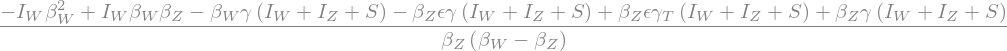

In [20]:
N_in_other_terms = S+I_W+I_Z
exp2_sub_N_in_other_terms = sympy.simplify(unusaul_equil[1].subs(N,N_in_other_terms))
exp3_sub_N_in_other_terms = sympy.simplify(unusaul_equil[2].subs(N,N_in_other_terms))
display(exp2_sub_N_in_other_terms,exp3_sub_N_in_other_terms)

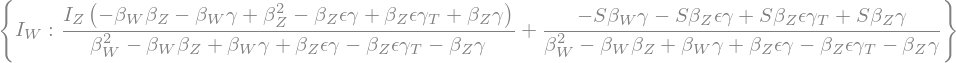

In [21]:
exp2_sub_N_in_other_terms=exp2_sub_N_in_other_terms-I_W
exp3_sub_N_in_other_terms=exp3_sub_N_in_other_terms-I_Z
sol = sympy.solve((exp2_sub_N_in_other_terms,exp3_sub_N_in_other_terms),(I_W,I_Z))
sol

#### Whilst not getting rid of the $S$ term in the equations for $I_W$ and $I_Z$, this does reveal that this equilibrium point is biologically meaningless. Either $\beta_W<\beta_Z$ and $I_W$ is negative, $\beta_Z<\beta_W$ and $I_Z$ is negative or $\beta_W=\beta_Z$ in which case $I_W=undefined$ and $I_Z=-undefined$.

## 2.2 Determining Equilibria Stability

We are not interested in whether the disease free equilibrium (DFE), the first equilibria, is stable. This can be found through deriving R0 using PyGom's matrix methodology for determining R0. 

Lets look at the stability of the non-DFEs, following recipe 8.2 of Otto & Day (2007). Needs to create Jacobian Matrix of the models ODEs.

The 2nd equilibrium as discussed in 1.2.1 is biologically meaningless. Therefore, we ignore this equilibrium.

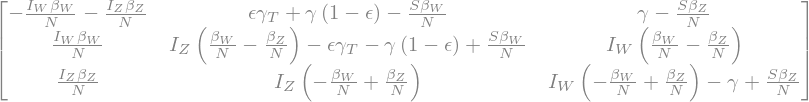

In [22]:
J_of_ODEs = ODEs.jacobian(X=[S,I_W,I_Z])
J_of_ODEs

Substitute the 1st non-disease free equilibrium (non-DFE) into the Jacobian matrix and determine Eigen values.

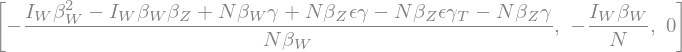

In [23]:
non_DFE_1 = {'S':equilibria[2][0],'I_W':equilibria[2][1],'I_Z':equilibria[2][2]}

J_of_ODEs_non_DFE_1 = J_of_ODEs.subs(non_DFE_1)
J_of_ODEs_non_DFE_1

eigs_J_non_DFE_1 = J_of_ODEs_non_DFE_1.eigenvals()
# The above code line enters the Eigen values as keys to a dictionary. 
# It would be more useful to have them as elements in a vector.
eigs_J_non_DFE_1 = [k  for  k in  eigs_J_non_DFE_1.keys()]
eigs_J_non_DFE_1

Substitute the 2nd non-disease free equilibrium (non-DFE) into the Jacobian matrix and determine Eigen values.

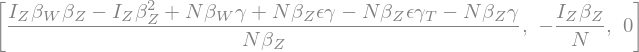

In [24]:
non_DFE_2 = {'S':equilibria[3][0],'I_W':equilibria[3][1],'I_Z':equilibria[3][2]}

J_of_ODEs_non_DFE_2 = J_of_ODEs.subs(non_DFE_2)
J_of_ODEs_non_DFE_2

eigs_J_non_DFE_2 = J_of_ODEs_non_DFE_2.eigenvals()
# The above code line enters the Eigen values as keys to a dictionary. 
# It would be more useful to have them as elements in a vector.
eigs_J_non_DFE_2 = [k  for  k in  eigs_J_non_DFE_2.keys()]
eigs_J_non_DFE_2

## 2.3 Function for Determining the Stable Endemic Equilibrium Infection Prevelance

In [25]:
# A rounding to sigfig function will prove useful:
def round_sf(number, significant):
    '''
    Rounds to a specified number of signicant figures. 
    '''
    return round(number, significant - len(str(number)))

In [26]:
def replace_inf_end_equil(param_values):
    '''
    Calculates the non-disease free equilibria for the replacement infection model ,
    as out lined in Spicknall et al 2013. Reuturning any non-DFE that are 
    that are biologically reasonable and locally stable.
    '''
    # Note if both strains have R0 values <1 there is no point in using this function.
    
    equil_pops = []
    # Setup Equilibrium populations as an empty list. If any of the endemic 
    # equilibria are found to be biologically feasible and stable they are appended to the list.
    
    #Basic Reproductive numbers from Spicknall 2013
    R0_W = beta_W/(gamma*(1-epsilon)+gamma_T*epsilon)
    R0_Z = beta_Z/gamma
    
    #Formula for the non-Disease Free Equilibria has been worked out in a jupyter notebook
    #and pasted here. NOTE with the first non-DFE the I_W population = N-S (I_Z=0),
    # and with the second non-DFE the I_Z population = N-S (I_W=0).
    # Therefore, only the formule for S are needed (see jupyter notebook).
    S_non_DFE_1 = N*(-epsilon*gamma + epsilon*gamma_T + gamma)/beta_W
    S_non_DFE_1 = S_non_DFE_1.subs(param_values)
    I_W_non_DFE_1 = param_values['N']-S_non_DFE_1
    I_Z_non_DFE_1 = 0
    S_non_DFE_2 = N*gamma/beta_Z
    S_non_DFE_2 = S_non_DFE_2.subs(param_values)
    I_W_non_DFE_2 = 0
    I_Z_non_DFE_2 = param_values['N']-S_non_DFE_2
    
    #The eigen values associated with jacobian matricies for the non-DFE have been 
    #worked out in a jupyter notebook and pasted here.
    eigs_J_non_DFE_1 = [-I_W*beta_W/N,
                        -(I_W*beta_W**2 - I_W*beta_W*beta_Z + N*beta_W*gamma + N*beta_Z*epsilon*gamma - N*beta_Z*epsilon*gamma_T - N*beta_Z*gamma)/(N*beta_W),
                        0]
    eigs_J_non_DFE_2 = [-I_Z*beta_Z/N,
                        (I_Z*beta_W*beta_Z - I_Z*beta_Z**2 + N*beta_W*gamma + N*beta_Z*epsilon*gamma - N*beta_Z*epsilon*gamma_T - N*beta_Z*gamma)/(N*beta_Z),
                        0]
    
    if math.isnan(S_non_DFE_1) or math.isnan(I_W_non_DFE_1) or math.isnan(I_Z_non_DFE_1) or math.isinf(S_non_DFE_1) or math.isinf(I_W_non_DFE_1) or math.isinf(I_Z_non_DFE_1):
        DFE_1_feasable = False
    else:
        DFE_1_feasable = True
    
    if DFE_1_feasable and round_sf(S_non_DFE_1,2) >= 0 and round_sf(I_W_non_DFE_1,2) >= 0 and round_sf(I_Z_non_DFE_1,2) >= 0:
        DFE_1_feasable = True
    else:
        DFE_1_feasable = False
    
    if math.isnan(S_non_DFE_2) or math.isnan(I_W_non_DFE_2) or math.isnan(I_Z_non_DFE_2) or math.isinf(S_non_DFE_2) or math.isinf(I_W_non_DFE_2) or math.isinf(I_Z_non_DFE_2):
        DFE_2_feasable = False
    else:
        DFE_2_feasable = True
    
    if DFE_2_feasable and round_sf(S_non_DFE_2,2) >= 0 and round_sf(I_W_non_DFE_2,2) >= 0 and round_sf(I_Z_non_DFE_2,2) >= 0:
        DFE_2_feasable = True
    else:
        DFE_2_feasable = False
    
    #Determine if R0_W is >=1, R0_Z<1 and the first DFE is biologically feasable.
    if R0_W.subs(param_values)>=1 and R0_Z.subs(param_values)<1 and DFE_1_feasable:
        equil_pops.append({'S':S_non_DFE_1,'I_W':I_W_non_DFE_1,'I_Z':I_Z_non_DFE_1})
    
    #Determine if R0_Z is >=1, R0_W<1 and the second DFE is biologically feasable.
    if R0_Z.subs(param_values)>=1 and R0_W.subs(param_values)<1 and DFE_2_feasable:   
        equil_pops.append({'S':S_non_DFE_2,'I_W':I_W_non_DFE_2,'I_Z':I_Z_non_DFE_2})
    
    #Determine if R0_W is >=1, R0_Z>=1 and the first DFE is biologically feasable but the second is not.
    if R0_W.subs(param_values)>=1 and R0_Z.subs(param_values)>=1 and DFE_1_feasable and DFE_2_feasable == False:
        equil_pops.append({'S':S_non_DFE_1,'I_W':I_W_non_DFE_1,'I_Z':I_Z_non_DFE_1})
    
    #Determine if R0_W is >=1, R0_Z>=1 and the second DFE is biologically feasable but the first is not.
    if R0_W.subs(param_values)>=1 and R0_Z.subs(param_values)>=1 and DFE_1_feasable  == False and DFE_2_feasable:
        equil_pops.append({'S':S_non_DFE_2,'I_W':I_W_non_DFE_2,'I_Z':I_Z_non_DFE_2})
        
    #Determine if R0_W is >=1, R0_Z>=1 and both DFEs are biologically feasable.
    if R0_W.subs(param_values)>=1 and R0_Z.subs(param_values)>=1 and DFE_1_feasable and DFE_2_feasable:   
        # If all the values for non-DFE_1 are >= 0, evaluate eigenavalues 
        # associated with the Jacobian matrix of non-DFE_1.
        # Need to be able to subsititute in equilibria formula, as well as the param values:
        vals_to_subs = copy.deepcopy(param_values)
        vals_to_subs['S'] = S_non_DFE_1
        vals_to_subs['I_W'] = I_W_non_DFE_1
        vals_to_subs['I_Z'] = I_Z_non_DFE_1
        if eigs_J_non_DFE_1[0].subs(vals_to_subs) <=0 and eigs_J_non_DFE_1[1].subs(vals_to_subs)<=0:
            # If the non-vero eigenavalues associated with the Jacobian matrix  
            # of non-DFE_1 are <= 0, the equil_pops is appended with non-DFE_1, 
            # as it is locally stable.
            equil_pops.append({'S':S_non_DFE_1,'I_W':I_W_non_DFE_1,'I_Z':I_Z_non_DFE_1})
        
        # If all the values for non-DFE_2 are >= 0, evaluate eigenavalues 
        # associated with the Jacobian matrix of non-DFE_2.
        # Need to be able to subsititute in equilibria formula, as well as the param values:
        vals_to_subs = copy.deepcopy(param_values)
        vals_to_subs['S'] =  S_non_DFE_2
        vals_to_subs['I_W'] = I_W_non_DFE_2
        vals_to_subs['I_Z'] = I_Z_non_DFE_2
        if eigs_J_non_DFE_2[0].subs(vals_to_subs) <=0 and eigs_J_non_DFE_2[1].subs(vals_to_subs)<=0:
            # If the non-vero eigenavalues associated with the Jacobian matrix  
            # of non-DFE_2 are <= 0, the equil_pops is appended with non-DFE_2, 
            # as it is locally stable.
            equil_pops.append({'S':S_non_DFE_2,'I_W':I_W_non_DFE_2,'I_Z':I_Z_non_DFE_2})
    
    return(equil_pops)

# 3 Endemic Equilibria Stability Anlyses of the Bi-Conversion Model from Spicknall et al (2013)

## 3.1 Deriving Equilibria & The Eigen Values Associated with Their Jacobian Matricies 

In [27]:
Eqn_S = -beta_W/N*I_W*S-beta_Z/N*I_Z*S+gamma*(1-epsilon)*I_W+gamma_T*epsilon*I_W+gamma*I_Z
Eqn_I_W = beta_W/N*I_W*S-gamma*(1-epsilon)*I_W-gamma_T*epsilon*I_W-rho*epsilon*I_W+phi*(1-epsilon)*I_Z
Eqn_I_Z = beta_Z/N*I_Z*S-gamma*I_Z+rho*epsilon*I_W-phi*(1-epsilon)*I_Z

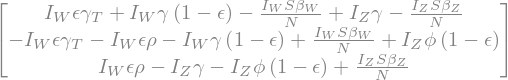

In [28]:
ODEs = sympy.Matrix([Eqn_S,Eqn_I_W,Eqn_I_Z])
ODEs

In [29]:
equilibria = sympy.solve(ODEs,[S, I_W, I_Z])

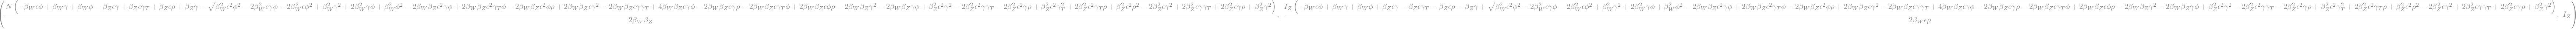

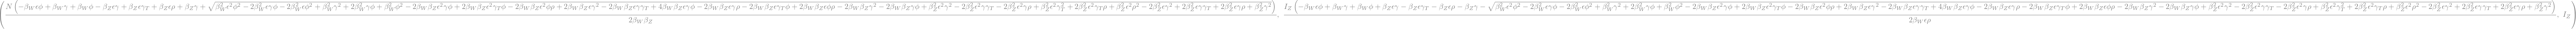

In [30]:
display(equilibria[0],equilibria[1],equilibria[2])

The disease free equilibrium (DFE) is the first vector.

In [31]:
DFE = equilibria[0]

We are not interested in whether the disease free equilibrium (DFE), the first equilibria, is stable. This can be found through deriving R0 using PyGom's matrix methodology for determining R0. 

Lets look at the stability of the non-DFEs, following recipe 8.2 of Otto & Day (2007). Needs to create Jacobian Matrix of the models ODEs.

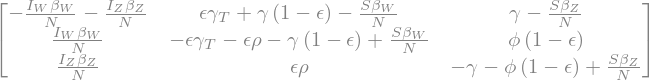

In [32]:
J_of_ODEs = ODEs.jacobian(X=[S,I_W,I_Z])
J_of_ODEs

Substitute the 1st non-disease free equilibrium (non-DFE) into the Jacobian matrix and determine Eigen values.

In [33]:
non_DFE_1 = {'S':equilibria[1][0],'I_W':equilibria[1][1],'I_Z':equilibria[1][2]}

J_of_ODEs_non_DFE_1 = J_of_ODEs.subs(non_DFE_1)
J_of_ODEs_non_DFE_1

eigs_J_non_DFE_1 = J_of_ODEs_non_DFE_1.eigenvals()
# The above code line enters the Eigen values as keys to a dictionary. 
# It would be more useful to have them as elements in a vector.
eigs_J_non_DFE_1 = [k  for  k in  eigs_J_non_DFE_1.keys()] 

C:\Users\mdgru\anaconda3\envs\amr\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\mdgru\anaconda3\envs\amr\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\mdgru\anaconda3\envs\amr\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\mdgru\anaconda3\envs\amr\lib\site-packages\IPython\lib\latextools.py:126: Matplotli

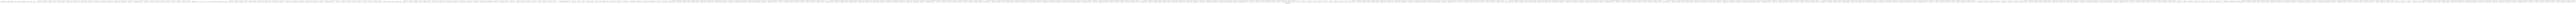

In [34]:
sympy.simplify(eigs_J_non_DFE_1[0])

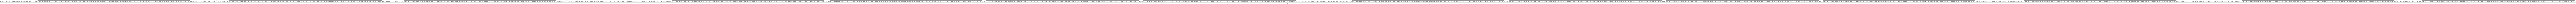

In [35]:
sympy.simplify(eigs_J_non_DFE_1[1])

In [36]:
sympy.simplify(eigs_J_non_DFE_1[2])

Substitute the 2nd non-disease free equilibrium (non-DFE) into the Jacobian matrix and determine Eigen values.

In [37]:
non_DFE_2 = {'S':equilibria[2][0],'I_W':equilibria[2][1],'I_Z':equilibria[2][2]}

J_of_ODEs_non_DFE_2 = J_of_ODEs.subs(non_DFE_2)
J_of_ODEs_non_DFE_2

eigs_J_non_DFE_2 = J_of_ODEs_non_DFE_2.eigenvals()
# The above code line enters the Eigen values as keys to a dictionary. 
# It would be more useful to have them as elements in a vector.
eigs_J_non_DFE_2 = [k  for  k in  eigs_J_non_DFE_2.keys()]

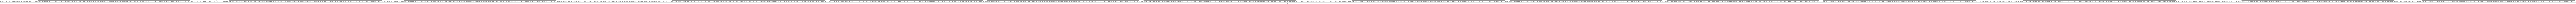

In [38]:
sympy.simplify(eigs_J_non_DFE_2[0])

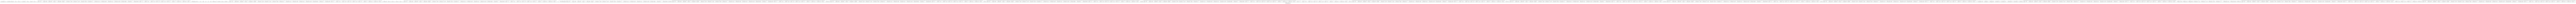

In [39]:
sympy.simplify(eigs_J_non_DFE_2[1])

In [40]:
sympy.simplify(eigs_J_non_DFE_2[2])

## 3.2 Function for Determining the Stable Endemic Equilibrium Infection Prevelance

In [41]:
# A rounding to sigfig function will prove useful:
def round_sf(number, significant):
    '''
    Rounds to a specified number of signicant figures. 
    '''
    return round(number, significant - len(str(number)))

In [42]:
def bi_directional_end_equil(param_values):
    '''
    Calculates the non-disease free equilibria for the uni and bi-directional convertion model ,
    as out lined in Spicknall et al 2013. Returning any non-DFE that are 
    that are biologically reasonable and locally stable.
    '''
    # Note if both strains have R0 values <1 there is no point in using this function.
    
    equil_pops = []
    # Setup Equilibrium populations as an empty list. If any of the endemic 
    # equilibria are found to be biologically feasible they are appended to the list.
    
    #Basic Reproductive numbers from Spicknall 2013
    R0_W = 2*beta_W*beta_Z/(beta_W*gamma+beta_Z*gamma-beta_Z*epsilon*gamma+beta_Z*epsilon*gamma_T+beta_W*phi-beta_W*epsilon*phi+beta_Z*epsilon*rho-
                            ((beta_W*(gamma+phi-epsilon*phi)+beta_Z*(gamma-epsilon*gamma+epsilon*(gamma_T+rho)))**2+4*beta_W*beta_Z*((-1+epsilon)*gamma**2+
                                                                                                                                    (-1+epsilon)*epsilon*gamma_T*phi-gamma*(phi+phi*epsilon**2+epsilon*(gamma_T-2*phi+rho))))**0.5)
    R0_Z = 2*beta_W*beta_Z/(beta_W*gamma+beta_Z*gamma-beta_Z*epsilon*gamma+beta_Z*epsilon*gamma_T+beta_W*phi-beta_W*epsilon*phi+beta_Z*epsilon*rho+
                            ((beta_W*(gamma+phi-epsilon*phi)+beta_Z*(gamma-epsilon*gamma+epsilon*(gamma_T+rho)))**2+4*beta_W*beta_Z*((-1+epsilon)*gamma**2+
                                                                                                                                    (-1+epsilon)*epsilon*gamma_T*phi-gamma*(phi+phi*epsilon**2+epsilon*(gamma_T-2*phi+rho))))**0.5)
    
    #Formula for the non-Disease Free Equilibria has been worked out in a jupyter notebook
    #and pasted here.
    non_DFE_1 = {
            'S':N*(-beta_W*epsilon*phi + beta_W*gamma + beta_W*phi - beta_Z*epsilon*gamma + beta_Z*epsilon*gamma_T + beta_Z*epsilon*rho + beta_Z*gamma - sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2))/(2*beta_W*beta_Z)
            ,
            'I_W':-I_Z*(beta_W*epsilon*phi - beta_W*gamma - beta_W*phi - beta_Z*epsilon*gamma + beta_Z*epsilon*gamma_T + beta_Z*epsilon*rho + beta_Z*gamma - sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2))/(2*beta_W*epsilon*rho)
            ,
            'I_Z':I_Z
            }
    
    # Need to track proportion so a value for I_Z=1 needs to substituted along with params values.
    vals_to_subs = copy.deepcopy(param_values)
    vals_to_subs['I_Z'] = 1
    S_non_DFE_1 = non_DFE_1['S'].subs(param_values)
    not_S_non_DFE_1 = param_values['N']-S_non_DFE_1
    prop_I_W_non_DFE_1 = non_DFE_1['I_W'].subs(vals_to_subs)/(1+non_DFE_1['I_W'].subs(vals_to_subs))
    if math.isnan(prop_I_W_non_DFE_1):
        prop_I_W_non_DFE_1 =1
    I_W_non_DFE_1 = (not_S_non_DFE_1*prop_I_W_non_DFE_1)
    I_Z_non_DFE_1 = (not_S_non_DFE_1*(1-prop_I_W_non_DFE_1))
    
    non_DFE_2 = {
            'S':N*(-beta_W*epsilon*phi + beta_W*gamma + beta_W*phi - beta_Z*epsilon*gamma + beta_Z*epsilon*gamma_T + beta_Z*epsilon*rho + beta_Z*gamma + sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2))/(2*beta_W*beta_Z)
            ,
            'I_W':-I_Z*(beta_W*epsilon*phi - beta_W*gamma - beta_W*phi - beta_Z*epsilon*gamma + beta_Z*epsilon*gamma_T + beta_Z*epsilon*rho + beta_Z*gamma + sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2))/(2*beta_W*epsilon*rho)
            ,
            'I_Z':I_Z
            }
    
    S_non_DFE_2 = non_DFE_2['S'].subs(param_values)
    not_S_non_DFE_2 = param_values['N']-S_non_DFE_2
    prop_I_W_non_DFE_2 = non_DFE_2['I_W'].subs(vals_to_subs)/(1+non_DFE_2['I_W'].subs(vals_to_subs))
    if math.isnan(prop_I_W_non_DFE_2):
        prop_I_W_non_DFE_2 =1
    I_W_non_DFE_2 = (not_S_non_DFE_2*prop_I_W_non_DFE_2)
    I_Z_non_DFE_2 = (not_S_non_DFE_2*(1-prop_I_W_non_DFE_2))
    
        
    #The Eigen values associated with jacobian matricies for the non-DFE have been 
    #derived in a jupyter notebook and pasted here.
    eigs_J_non_DFE_1 = [I_Z*beta_W*phi/(4*N*rho) - I_Z*beta_W*gamma/(4*N*epsilon*rho) - I_Z*beta_W*phi/(4*N*epsilon*rho) - I_Z*beta_Z*gamma/(4*N*rho) + I_Z*beta_Z*gamma_T/(4*N*rho) - I_Z*beta_Z/(4*N) + I_Z*beta_Z*gamma/(4*N*epsilon*rho) - I_Z*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)/(4*N*epsilon*rho) - beta_W*epsilon*phi/(4*beta_Z) + beta_W*gamma/(4*beta_Z) + beta_W*phi/(4*beta_Z) + epsilon*gamma/4 - epsilon*gamma_T/4 + epsilon*phi/4 - epsilon*rho/4 - gamma/2 - phi/4 - sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)/(4*beta_Z) - beta_Z*epsilon*gamma/(4*beta_W) + beta_Z*epsilon*gamma_T/(4*beta_W) + beta_Z*epsilon*rho/(4*beta_W) + beta_Z*gamma/(4*beta_W) - sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)/(4*beta_W) - sqrt(-8*I_Z*N*beta_W*beta_Z**2*epsilon*rho*(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi - beta_W*epsilon*phi*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + 2*beta_W*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_W*gamma*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_W*phi*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2 + beta_Z*epsilon*gamma*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - beta_Z*epsilon*gamma_T*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - beta_Z*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - beta_Z*gamma*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)) + (-I_Z*beta_W**2*beta_Z*epsilon*phi + I_Z*beta_W**2*beta_Z*gamma + I_Z*beta_W**2*beta_Z*phi + I_Z*beta_W*beta_Z**2*epsilon*gamma - I_Z*beta_W*beta_Z**2*epsilon*gamma_T + I_Z*beta_W*beta_Z**2*epsilon*rho - I_Z*beta_W*beta_Z**2*gamma + I_Z*beta_W*beta_Z*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + N*beta_W**2*epsilon**2*phi*rho - N*beta_W**2*epsilon*gamma*rho - N*beta_W**2*epsilon*phi*rho - N*beta_W*beta_Z*epsilon**2*gamma*rho + N*beta_W*beta_Z*epsilon**2*gamma_T*rho - N*beta_W*beta_Z*epsilon**2*phi*rho + N*beta_W*beta_Z*epsilon**2*rho**2 + 2*N*beta_W*beta_Z*epsilon*gamma*rho + N*beta_W*beta_Z*epsilon*phi*rho + N*beta_W*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + N*beta_Z**2*epsilon**2*gamma*rho - N*beta_Z**2*epsilon**2*gamma_T*rho - N*beta_Z**2*epsilon**2*rho**2 - N*beta_Z**2*epsilon*gamma*rho + N*beta_Z*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2))**2)/(4*N*beta_W*beta_Z*epsilon*rho),
                        I_Z*beta_W*phi/(4*N*rho) - I_Z*beta_W*gamma/(4*N*epsilon*rho) - I_Z*beta_W*phi/(4*N*epsilon*rho) - I_Z*beta_Z*gamma/(4*N*rho) + I_Z*beta_Z*gamma_T/(4*N*rho) - I_Z*beta_Z/(4*N) + I_Z*beta_Z*gamma/(4*N*epsilon*rho) - I_Z*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)/(4*N*epsilon*rho) - beta_W*epsilon*phi/(4*beta_Z) + beta_W*gamma/(4*beta_Z) + beta_W*phi/(4*beta_Z) + epsilon*gamma/4 - epsilon*gamma_T/4 + epsilon*phi/4 - epsilon*rho/4 - gamma/2 - phi/4 - sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)/(4*beta_Z) - beta_Z*epsilon*gamma/(4*beta_W) + beta_Z*epsilon*gamma_T/(4*beta_W) + beta_Z*epsilon*rho/(4*beta_W) + beta_Z*gamma/(4*beta_W) - sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)/(4*beta_W) + sqrt(-8*I_Z*N*beta_W*beta_Z**2*epsilon*rho*(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi - beta_W*epsilon*phi*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + 2*beta_W*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_W*gamma*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_W*phi*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2 + beta_Z*epsilon*gamma*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - beta_Z*epsilon*gamma_T*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - beta_Z*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - beta_Z*gamma*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)) + (-I_Z*beta_W**2*beta_Z*epsilon*phi + I_Z*beta_W**2*beta_Z*gamma + I_Z*beta_W**2*beta_Z*phi + I_Z*beta_W*beta_Z**2*epsilon*gamma - I_Z*beta_W*beta_Z**2*epsilon*gamma_T + I_Z*beta_W*beta_Z**2*epsilon*rho - I_Z*beta_W*beta_Z**2*gamma + I_Z*beta_W*beta_Z*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + N*beta_W**2*epsilon**2*phi*rho - N*beta_W**2*epsilon*gamma*rho - N*beta_W**2*epsilon*phi*rho - N*beta_W*beta_Z*epsilon**2*gamma*rho + N*beta_W*beta_Z*epsilon**2*gamma_T*rho - N*beta_W*beta_Z*epsilon**2*phi*rho + N*beta_W*beta_Z*epsilon**2*rho**2 + 2*N*beta_W*beta_Z*epsilon*gamma*rho + N*beta_W*beta_Z*epsilon*phi*rho + N*beta_W*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + N*beta_Z**2*epsilon**2*gamma*rho - N*beta_Z**2*epsilon**2*gamma_T*rho - N*beta_Z**2*epsilon**2*rho**2 - N*beta_Z**2*epsilon*gamma*rho + N*beta_Z*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2))**2)/(4*N*beta_W*beta_Z*epsilon*rho),
                        0]
    eigs_J_non_DFE_2 = [I_Z*beta_W*phi/(4*N*rho) - I_Z*beta_W*gamma/(4*N*epsilon*rho) - I_Z*beta_W*phi/(4*N*epsilon*rho) - I_Z*beta_Z*gamma/(4*N*rho) + I_Z*beta_Z*gamma_T/(4*N*rho) - I_Z*beta_Z/(4*N) + I_Z*beta_Z*gamma/(4*N*epsilon*rho) + I_Z*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)/(4*N*epsilon*rho) - beta_W*epsilon*phi/(4*beta_Z) + beta_W*gamma/(4*beta_Z) + beta_W*phi/(4*beta_Z) + epsilon*gamma/4 - epsilon*gamma_T/4 + epsilon*phi/4 - epsilon*rho/4 - gamma/2 - phi/4 + sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)/(4*beta_Z) - beta_Z*epsilon*gamma/(4*beta_W) + beta_Z*epsilon*gamma_T/(4*beta_W) + beta_Z*epsilon*rho/(4*beta_W) + beta_Z*gamma/(4*beta_W) + sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)/(4*beta_W) - sqrt(-8*I_Z*N*beta_W*beta_Z**2*epsilon*rho*(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_W*epsilon*phi*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - 2*beta_W*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - beta_W*gamma*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - beta_W*phi*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2 - beta_Z*epsilon*gamma*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_Z*epsilon*gamma_T*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_Z*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_Z*gamma*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)) + (I_Z*beta_W**2*beta_Z*epsilon*phi - I_Z*beta_W**2*beta_Z*gamma - I_Z*beta_W**2*beta_Z*phi - I_Z*beta_W*beta_Z**2*epsilon*gamma + I_Z*beta_W*beta_Z**2*epsilon*gamma_T - I_Z*beta_W*beta_Z**2*epsilon*rho + I_Z*beta_W*beta_Z**2*gamma + I_Z*beta_W*beta_Z*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - N*beta_W**2*epsilon**2*phi*rho + N*beta_W**2*epsilon*gamma*rho + N*beta_W**2*epsilon*phi*rho + N*beta_W*beta_Z*epsilon**2*gamma*rho - N*beta_W*beta_Z*epsilon**2*gamma_T*rho + N*beta_W*beta_Z*epsilon**2*phi*rho - N*beta_W*beta_Z*epsilon**2*rho**2 - 2*N*beta_W*beta_Z*epsilon*gamma*rho - N*beta_W*beta_Z*epsilon*phi*rho + N*beta_W*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - N*beta_Z**2*epsilon**2*gamma*rho + N*beta_Z**2*epsilon**2*gamma_T*rho + N*beta_Z**2*epsilon**2*rho**2 + N*beta_Z**2*epsilon*gamma*rho + N*beta_Z*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2))**2)/(4*N*beta_W*beta_Z*epsilon*rho),
                        I_Z*beta_W*phi/(4*N*rho) - I_Z*beta_W*gamma/(4*N*epsilon*rho) - I_Z*beta_W*phi/(4*N*epsilon*rho) - I_Z*beta_Z*gamma/(4*N*rho) + I_Z*beta_Z*gamma_T/(4*N*rho) - I_Z*beta_Z/(4*N) + I_Z*beta_Z*gamma/(4*N*epsilon*rho) + I_Z*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)/(4*N*epsilon*rho) - beta_W*epsilon*phi/(4*beta_Z) + beta_W*gamma/(4*beta_Z) + beta_W*phi/(4*beta_Z) + epsilon*gamma/4 - epsilon*gamma_T/4 + epsilon*phi/4 - epsilon*rho/4 - gamma/2 - phi/4 + sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)/(4*beta_Z) - beta_Z*epsilon*gamma/(4*beta_W) + beta_Z*epsilon*gamma_T/(4*beta_W) + beta_Z*epsilon*rho/(4*beta_W) + beta_Z*gamma/(4*beta_W) + sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)/(4*beta_W) + sqrt(-8*I_Z*N*beta_W*beta_Z**2*epsilon*rho*(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_W*epsilon*phi*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - 2*beta_W*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - beta_W*gamma*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - beta_W*phi*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2 - beta_Z*epsilon*gamma*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_Z*epsilon*gamma_T*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_Z*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) + beta_Z*gamma*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2)) + (I_Z*beta_W**2*beta_Z*epsilon*phi - I_Z*beta_W**2*beta_Z*gamma - I_Z*beta_W**2*beta_Z*phi - I_Z*beta_W*beta_Z**2*epsilon*gamma + I_Z*beta_W*beta_Z**2*epsilon*gamma_T - I_Z*beta_W*beta_Z**2*epsilon*rho + I_Z*beta_W*beta_Z**2*gamma + I_Z*beta_W*beta_Z*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - N*beta_W**2*epsilon**2*phi*rho + N*beta_W**2*epsilon*gamma*rho + N*beta_W**2*epsilon*phi*rho + N*beta_W*beta_Z*epsilon**2*gamma*rho - N*beta_W*beta_Z*epsilon**2*gamma_T*rho + N*beta_W*beta_Z*epsilon**2*phi*rho - N*beta_W*beta_Z*epsilon**2*rho**2 - 2*N*beta_W*beta_Z*epsilon*gamma*rho - N*beta_W*beta_Z*epsilon*phi*rho + N*beta_W*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2) - N*beta_Z**2*epsilon**2*gamma*rho + N*beta_Z**2*epsilon**2*gamma_T*rho + N*beta_Z**2*epsilon**2*rho**2 + N*beta_Z**2*epsilon*gamma*rho + N*beta_Z*epsilon*rho*sqrt(beta_W**2*epsilon**2*phi**2 - 2*beta_W**2*epsilon*gamma*phi - 2*beta_W**2*epsilon*phi**2 + beta_W**2*gamma**2 + 2*beta_W**2*gamma*phi + beta_W**2*phi**2 - 2*beta_W*beta_Z*epsilon**2*gamma*phi + 2*beta_W*beta_Z*epsilon**2*gamma_T*phi - 2*beta_W*beta_Z*epsilon**2*phi*rho + 2*beta_W*beta_Z*epsilon*gamma**2 - 2*beta_W*beta_Z*epsilon*gamma*gamma_T + 4*beta_W*beta_Z*epsilon*gamma*phi - 2*beta_W*beta_Z*epsilon*gamma*rho - 2*beta_W*beta_Z*epsilon*gamma_T*phi + 2*beta_W*beta_Z*epsilon*phi*rho - 2*beta_W*beta_Z*gamma**2 - 2*beta_W*beta_Z*gamma*phi + beta_Z**2*epsilon**2*gamma**2 - 2*beta_Z**2*epsilon**2*gamma*gamma_T - 2*beta_Z**2*epsilon**2*gamma*rho + beta_Z**2*epsilon**2*gamma_T**2 + 2*beta_Z**2*epsilon**2*gamma_T*rho + beta_Z**2*epsilon**2*rho**2 - 2*beta_Z**2*epsilon*gamma**2 + 2*beta_Z**2*epsilon*gamma*gamma_T + 2*beta_Z**2*epsilon*gamma*rho + beta_Z**2*gamma**2))**2)/(4*N*beta_W*beta_Z*epsilon*rho),
                        0]
    
    
    if math.isnan(S_non_DFE_1) or math.isnan(I_W_non_DFE_1) or math.isnan(I_Z_non_DFE_1) or math.isinf(S_non_DFE_1) or math.isinf(I_W_non_DFE_1) or math.isinf(I_Z_non_DFE_1):
        DFE_1_feasable = False
    else:
        DFE_1_feasable = True
    
    if DFE_1_feasable and round_sf(S_non_DFE_1,2) >= 0 and round_sf(I_W_non_DFE_1,2) >= 0 and round_sf(I_Z_non_DFE_1,2) >= 0:
        DFE_1_feasable = True
    else:
        DFE_1_feasable = False
    
    if math.isnan(S_non_DFE_2) or math.isnan(I_W_non_DFE_2) or math.isnan(I_Z_non_DFE_2) or math.isinf(S_non_DFE_2) or math.isinf(I_W_non_DFE_2) or math.isinf(I_Z_non_DFE_2):
        DFE_2_feasable = False
    else:
        DFE_2_feasable = True
    
    if DFE_2_feasable and round_sf(S_non_DFE_2,2) >= 0 and round_sf(I_W_non_DFE_2,2) >= 0 and round_sf(I_Z_non_DFE_2,2) >= 0:
        DFE_2_feasable = True
    else:
        DFE_2_feasable = False
    
    #Determine if R0_W is >=1, R0_Z<1 and the first DFE is biologically feasable.
    if R0_W.subs(param_values)>=1 and R0_Z.subs(param_values)<1 and DFE_1_feasable:
        equil_pops.append({'S':S_non_DFE_1,'I_W':I_W_non_DFE_1,'I_Z':I_Z_non_DFE_1})
    
    #Determine if R0_Z is >=1, R0_W<1 and the second DFE is biologically feasable.
    if R0_Z.subs(param_values)>=1 and R0_W.subs(param_values)<1 and DFE_2_feasable:   
        equil_pops.append({'S':S_non_DFE_2,'I_W':I_W_non_DFE_2,'I_Z':I_Z_non_DFE_2})
    
    #Determine if R0_W is >=1, R0_Z>=1 and the first DFE is biologically feasable but the second is not.
    if R0_W.subs(param_values)>=1 and R0_Z.subs(param_values)>=1 and DFE_1_feasable and DFE_2_feasable == False:
        equil_pops.append({'S':S_non_DFE_1,'I_W':I_W_non_DFE_1,'I_Z':I_Z_non_DFE_1})
    
    #Determine if R0_W is >=1, R0_Z>=1 and the second DFE is biologically feasable but the first is not.
    if R0_W.subs(param_values)>=1 and R0_Z.subs(param_values)>=1 and DFE_1_feasable  == False and DFE_2_feasable:
        equil_pops.append({'S':S_non_DFE_2,'I_W':I_W_non_DFE_2,'I_Z':I_Z_non_DFE_2})
        
    #Determine if R0_W is >=1, R0_Z>=1 and both DFEs are biologically feasable.
    if R0_W.subs(param_values)>=1 and R0_Z.subs(param_values)>=1 and DFE_1_feasable and DFE_2_feasable:
        # There are several denominators in eigen values associated with both DFEs (see jupyter notebook) that can be 0 if rho or epsilon = 0.
        # This means sympy's substitution function can produce undefined values (NaN values).
        # Therefore as Spicknall et al (2013) found that the largest of the R0 values was the R0 that described the system.
        # We can choose between the DFE's by using R0s.
        if param_values['epsilon']==0 or param_values['rho'] == 0:
            if R0_W.subs(param_values)> R0_Z.subs(param_values):
                equil_pops.append({'S':S_non_DFE_1,'I_W':I_W_non_DFE_1,'I_Z':I_Z_non_DFE_1})
            else:
                equil_pops.append({'S':S_non_DFE_2,'I_W':I_W_non_DFE_2,'I_Z':I_Z_non_DFE_2})
        else:
            # Need to be able to subsititute in equilibria formula, as well as the param values:
            vals_to_subs = copy.deepcopy(param_values)
            vals_to_subs['S'] = S_non_DFE_1
            vals_to_subs['I_W'] = I_W_non_DFE_1
            vals_to_subs['I_Z'] = I_Z_non_DFE_1
            # Both DFE associated eigen values can be complex and we are only 
            # interested in the real part so:
            eig_1_J_non_DFE_1 = sympy.re(eigs_J_non_DFE_1[0].subs(vals_to_subs))
            eig_2_J_non_DFE_1 = sympy.re(eigs_J_non_DFE_1[1].subs(vals_to_subs))
            if eig_1_J_non_DFE_1 <=0 and eig_2_J_non_DFE_1 <=0:
                # If the non-vero eigenavalues associated with the Jacobian matrix  
                # of non-DFE_1 are <= 0, the equil_pops is appended with non-DFE_1, 
                # as it is locally stable.
                equil_pops.append({'S':S_non_DFE_1,'I_W':I_W_non_DFE_1,'I_Z':I_Z_non_DFE_1})
            
            # If all the values for non-DFE_2 are >= 0, evaluate eigenavalues 
            # associated with the Jacobian matrix of non-DFE_2.
            # Need to be able to subsititute in equilibria formula, as well as the param values:
            vals_to_subs = copy.deepcopy(param_values)
            vals_to_subs['S'] =  S_non_DFE_2
            vals_to_subs['I_W'] = I_W_non_DFE_2
            vals_to_subs['I_Z'] = I_Z_non_DFE_2
            # Both DFE associated eigen values can be complex and we are only 
            # interested in the real part so:
            eig_1_J_non_DFE_2 = sympy.re(eigs_J_non_DFE_2[0].subs(vals_to_subs))
            eig_2_J_non_DFE_2 = sympy.re(eigs_J_non_DFE_2[1].subs(vals_to_subs))
            if eig_1_J_non_DFE_2 <=0 and eig_2_J_non_DFE_2 <=0:
                # If the non-vero eigenavalues associated with the Jacobian matrix  
                # of non-DFE_2 are <= 0, the equil_pops is appended with non-DFE_2, 
                # as it is locally stable.
                equil_pops.append({'S':S_non_DFE_2,'I_W':I_W_non_DFE_2,'I_Z':I_Z_non_DFE_2})
    
    return(equil_pops)

# 4 Endemic Equilibria Stability Anlyses of the Super Infection Model from Spicknall et al (2013)

## 4.1 Deriving Equilibria

In [43]:
Eqn_S = - beta_W/N*(I_W+q*I_WZ)*S - beta_Z/N*(I_Z+q*I_WZ)*S + gamma*(1-epsilon)*I_W + gamma_T*epsilon*I_W + gamma*I_Z
Eqn_I_W = beta_W/N*S*(I_W+q*I_WZ) - beta_Z/N*I_W*(I_Z+q*I_WZ) - gamma*(1-epsilon)*I_W - gamma_T*epsilon*I_W + gamma*I_WZ
Eqn_I_Z = beta_Z/N*S*(I_Z+q*I_WZ) - beta_W/N*I_Z*(I_W+q*I_WZ) - gamma*I_Z + (1-epsilon)*gamma*I_WZ + epsilon*gamma_T*I_WZ
Eqn_I_WZ = beta_W/N*I_Z*(I_W+q*I_WZ) + beta_Z/N*I_W*(I_Z+q*I_WZ) - (1-epsilon)*gamma*I_WZ - epsilon*gamma_T*I_WZ - gamma*I_WZ

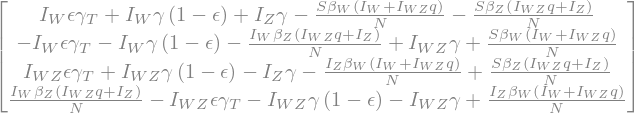

In [44]:
ODE_mat = sympy.Matrix([Eqn_S,Eqn_I_W,Eqn_I_Z,Eqn_I_WZ])
ODE_mat

**NOTE** NEXT CELL MAY RUN FOREVER. A python script containing the same code as this section was run on a server for a week. After this time no solution was found. Hence the code is silenced.

In [45]:
#equilibria = sympy.solve(ODE_mat,[S, I_W, I_Z,I_WZ])
#equilibria

# 5. Endemic Equilibria Stability Anlyses of the Full Coinfection Model from Spicknall et al (2013)
## 5.1 Deriving Equilibria

In [46]:
I_WW, I_ZZ = sympy.symbols('I_WW I_ZZ')

In [47]:
Eqn_S = - S*beta_W*(I_W + q*(2*I_WW + I_WZ))/N - S*beta_Z*(I_Z + q*(I_WZ + 2*I_ZZ))/N + gamma*(1-epsilon)*I_W + gamma_T*epsilon*I_W + gamma*I_Z + gamma*(1-epsilon)*I_WW + gamma_T*epsilon*I_WW + I_ZZ*gamma
Eqn_I_W = S*beta_W*(I_W + q*(2*I_WW + I_WZ))/N - I_W*beta_Z*(I_Z + q*(I_WZ + 2*I_ZZ))/N - I_W*beta_W*(I_W + q*(2*I_WW + I_WZ))/N - gamma*(1-epsilon)*I_W - gamma_T*epsilon*I_W + gamma*I_WZ
Eqn_I_Z = S*beta_Z*(I_Z + q*(I_WZ + 2*I_ZZ))/N - I_Z*beta_W*(I_W + q*(2*I_WW + I_WZ))/N - I_Z*beta_Z*(I_Z + q*(I_WZ + 2*I_ZZ))/N - gamma*I_Z + (1-epsilon)*gamma*I_WZ + epsilon*gamma_T*I_WZ
Eqn_I_WZ = beta_W/N*I_Z*(I_W+q*(2*I_WW + I_WZ)) + beta_Z/N*I_W*(I_Z+q*(I_WZ + 2*I_ZZ)) - (1-epsilon)*gamma*I_WZ - epsilon*gamma_T*I_WZ - gamma*I_WZ
Eqn_I_WW = I_W*beta_W*(I_W + q*(2*I_WW + I_WZ))/N - gamma*(1-epsilon)*I_WW - gamma_T*epsilon*I_WW
Eqn_I_ZZ = I_Z*beta_Z*(I_Z + q*(I_WZ + 2*I_ZZ))/N - I_ZZ*gamma

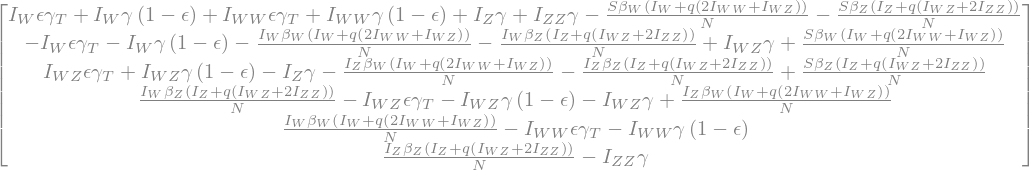

In [48]:
ODE_mat = sympy.Matrix([Eqn_S,Eqn_I_W,Eqn_I_Z,Eqn_I_WZ,Eqn_I_WW,Eqn_I_ZZ])
ODE_mat

**NOTE** NEXT CELL MAY RUN FOREVER.Finding a solution this way runs into the same problem as the Superinfection model. Hence the code is silenced.

In [49]:
#equilibria = sympy.solve(ODE_mat,[S, I_W, I_Z,I_WZ,I_WW,I_ZZ])
#equilibria

## 5.2 Endemic Equilibria Stability Analyses of the Full Co-Infection model just Anti-microbial sensitive strain.

In [50]:
Eqn_S = - S*beta_W*(I_W + q*(2*I_WW))/N + I_W*(epsilon*gamma_T + gamma*(1 - epsilon)) + I_WW*(epsilon*gamma_T + gamma*(1 - epsilon))

Eqn_I_W = S*beta_W*(I_W + q*(2*I_WW))/N - I_W*(epsilon*gamma_T + gamma*(1 - epsilon)) - I_W*beta_W*(I_W + q*(2*I_WW))/N

Eqn_I_WW = I_W*beta_W*(I_W + q*(2*I_WW))/N - I_WW*(epsilon*gamma_T + gamma*(1 - epsilon))

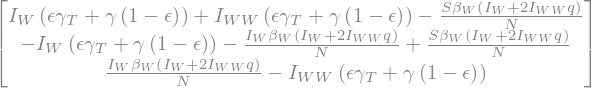

In [51]:
ODEs = sympy.Matrix([Eqn_S, Eqn_I_W, Eqn_I_WW])
ODEs

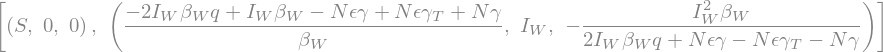

In [52]:
equilibria = sympy.solve(ODEs,[S, I_W, I_WW])
equilibria

The disease free equilibrium (DFE) is the first vector.

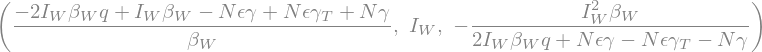

In [53]:
DFE = equilibria[0]
EE = equilibria[1]
display(DFE,EE)

The endemic equilibium for the AMS strain is not that useful lets try:

### 5.1.1 Substituting $q=0.5$ in the system.

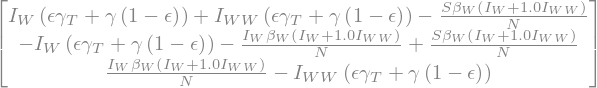

In [54]:
ODEs_q_is_a_half = ODEs.subs({q:0.5})
display(ODEs_q_is_a_half)

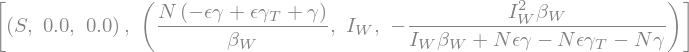

In [55]:
equilibria_q_is_a_half = sympy.solve(ODEs_q_is_a_half,[S, I_W, I_WW])
equilibria_q_is_a_half

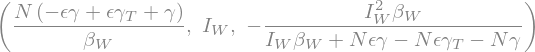

In [57]:
EE_q_is_a_half = equilibria_q_is_a_half[1]
display(EE_q_is_a_half)

Solve $I_W$ knowing that $N = S + I_W + I_{WW}$.

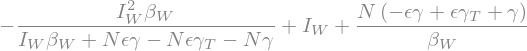

In [58]:
test_eqn = EE_q_is_a_half[0] + EE_q_is_a_half[1] + EE_q_is_a_half[2]
test_eqn

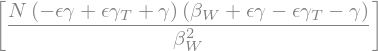

In [59]:
test_sol = sympy.solve(test_eqn-N,I_W)
test_sol

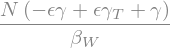

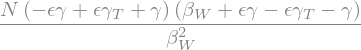

In [60]:
EE_S_q_is_a_half = EE_q_is_a_half[0]
EE_I_W_q_is_a_half = test_sol[0]
display(EE_S_q_is_a_half,EE_I_W_q_is_a_half)

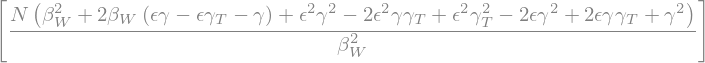

In [61]:
EE_I_WW_q_is_a_half = sympy.solve(N-(EE_S_q_is_a_half+EE_I_W_q_is_a_half+I_WW),I_WW)
EE_I_WW_q_is_a_half

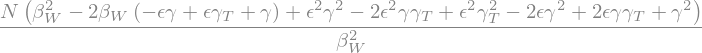

In [62]:
EE_I_WW_q_is_a_half = EE_I_WW_q_is_a_half[0].simplify()
EE_I_WW_q_is_a_half

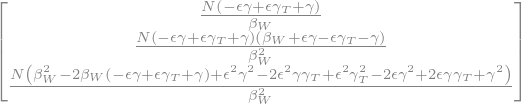

In [63]:
EE_q_is_a_half = sympy.Matrix([EE_S_q_is_a_half, EE_I_W_q_is_a_half, EE_I_WW_q_is_a_half])
EE_q_is_a_half

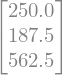

In [64]:
EE_q_is_a_half.subs({'N':1e3,'beta_W': 0.04 , 'beta_Z': 0.015,'gamma': 0.01,'gamma_T': 0.1,'epsilon':0,'q':0.5})